In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# Read in words

words = open(file='../data/names.txt',mode='r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [30]:
len(words)

32033

In [31]:
chars   = sorted(set(''.join(words)))
stoi    = {s:i+1 for i,s in enumerate(chars)} # string to integer
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()} # integer to string
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [32]:
# Building the dataset
block_size = 3

X, Y = [], [] # x is input, y is label (i.e. pred)
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
    
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y) 

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


We are going to create a neural net similar to the one documented in Bengio et al. 2003 MLP language model paper[https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf]


![neural](./img/neural-net.png)

Below we have created 32 examples with 3 inputs (i.e. 3 chars inputted to each example) into the model 

In [33]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

Lets create embeddings in a two dimensional space. We have 27 characters, each of which will have a 2d embedding

In [34]:
C = torch.randn((27,2)) # 27 characters each which have 2 dimensional space
C

tensor([[ 0.5241,  1.0492],
        [-0.8701, -2.1745],
        [-0.9746, -0.0244],
        [-0.8785, -0.4778],
        [-0.8005, -0.8776],
        [-0.0806, -0.8824],
        [-1.9898, -0.0598],
        [-1.4152,  0.0528],
        [ 0.5252, -0.7512],
        [ 0.5426, -0.5587],
        [ 1.0940, -0.1306],
        [ 1.2883, -1.4281],
        [ 0.8839, -0.0879],
        [ 1.6668, -0.0086],
        [-0.8450,  1.7513],
        [-0.9684,  0.7389],
        [ 0.9974, -2.3210],
        [-0.9386,  0.2866],
        [-0.7642,  0.7344],
        [-0.1142,  0.3791],
        [ 0.3383, -0.9219],
        [ 0.0933,  0.2661],
        [ 1.1856, -1.3222],
        [-0.1599, -1.1757],
        [-0.8736,  0.1541],
        [ 0.6926, -0.8508],
        [-1.4164, -0.1651]])

The below gets the embedding value for 5th index

In [35]:
C[5]

tensor([-0.0806, -0.8824])

We can also feed in multidimension tensors. In our case, we can feed in C[X] where X = torch.Size([32, 3]) 32 examples with 3 inputs for each

Creates our embedding

In [36]:
# embed all our values
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

Now lets create layer 1

![layer](./img/neural-net-layer-1.png)

looking at the image above and the fact that torch.Size([32, 3, 2]), we require 6 weights as 3*2 (i.e. 3 inputs with in 2 dimensional embedding)

Number of neurons is a variable which we can decide on, we choose 100 

For biases, we'll also need 100 to match the neurons

In [37]:
# Create weights for next layer 
W1 = torch.rand((6, 100))
b1 = torch.rand(100)

Next we want to muiltiply our weights and add bias but we cant as emb is a torch.Size([32, 3, 2])

we can use pytorch view to do this. We concatenate across dimension 1 which combines the 3 different inputs (i.e. blocks of chars)

In [38]:
# -1 just lets pytorch figure out the value required
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # concat our original emb to a 32 * 6 so we can multiply weight and add bias
h

tensor([[ 0.9976,  0.9807,  0.9905,  ...,  0.9637,  0.9830,  0.9998],
        [ 0.9884,  0.8970,  0.8984,  ...,  0.9332,  0.8182,  0.9754],
        [ 0.9977,  0.6326,  0.8278,  ...,  0.9027,  0.9097,  0.9758],
        ...,
        [ 0.9496, -0.7472, -0.7826,  ...,  0.4479,  0.8044, -0.1972],
        [-0.2901, -0.0064, -0.4435,  ..., -0.7577, -0.2099, -0.8968],
        [-0.4025, -0.5325, -0.8168,  ..., -0.3561, -0.7108, -0.9922]])

In [39]:
h.shape

torch.Size([32, 100])

Now let's create the final layer
![layer](./img/neural-net-layer-2.png)

In [40]:
W2 = torch.randn(100, 27) # input is 100 neurons, and output is 27 as 27 possible characters
b2 = torch.randn(27)

In [41]:
logits = h @ W2 + b2

In [42]:
logits.shape

torch.Size([32, 27])

Exponentiate logits and normalize

In [43]:
counts = logits.exp() # make sure all values are positive and amplify differences

In [44]:
prob = counts / counts.sum(1, keepdims=True) # normalise to get prob distribution, sum along second dimension

In [45]:
prob.shape

torch.Size([32, 27])

Now we need to introduce our prediction sequence Y

We want to identify the probability from each row of prob, we want to pluck out the probability assigned to the correct character

In [46]:
prob[torch.arange(32), Y] # for each row, pick out the probability of the correct Y value

tensor([2.1752e-21, 1.0115e-05, 6.4996e-05, 1.1503e-07, 7.3987e-02, 2.5579e-15,
        3.6104e-08, 3.2618e-08, 4.5419e-10, 6.6508e-06, 1.7308e-04, 4.7759e-11,
        1.0254e-08, 5.9473e-10, 3.0140e-07, 2.7840e-16, 1.9187e-08, 1.1031e-07,
        1.1509e-07, 3.7670e-03, 9.9369e-01, 9.4534e-11, 1.3872e-02, 3.3465e-07,
        4.8122e-03, 9.8821e-08, 2.0986e-15, 2.5855e-08, 9.1034e-09, 1.9547e-07,
        2.2995e-06, 7.6528e-12])

In [47]:
"""
Now let's get the negative log likelihood loss
"""

loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.3284)

# ------------ now made respectable :) ---------------

# Broken down into training, dev, and test set

In [48]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80% 
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [49]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [64]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [51]:
sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [63]:
for p in parameters:
    p.requires_grad = True

Another way to calculate loss is to use pytorch cross entropy

In [53]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre # learning rates
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [54]:
lri, lossi, stepi = [], [], [] # learning rates used and losses

In [55]:
# Forward pass
for i in range(30000):

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    emb = C[Xtr[ix]] # index into X to only grab ix rows (32, 3, 2)
    # -1 just lets pytorch figure out the value required
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # concat our original emb to a 32 * 6 so we can multiply weight and add bias
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass 
    for p in parameters:
        p.grad = None # reset weights    
    loss.backward()
    # Update
    # lr = lrs[i] # vary the learning rate, start off with small learning rate and go to large learning rate
    lr = 0.05
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())

plot the learning rates and loss exponent to see what the optimal learning rate is. below we can deduce .1 us a good learning rate as exponent pf -1 is .1

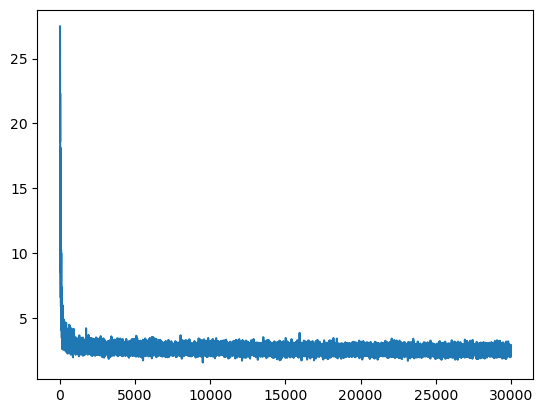

In [56]:

plt.plot(stepi, lossi)

Get loss for all of Xdev and all of Ydev, above we are calculating loss of minibatches

In [57]:
# Training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # concat our original emb to a 32 * 6 so we can multiply weight and add bias
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4540, grad_fn=<NllLossBackward0>)

In [58]:
# evaluate dev loss
# Evaluate training loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # concat our original emb to a 32 * 6 so we can multiply weight and add bias
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4530, grad_fn=<NllLossBackward0>)

In [62]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

Now lets split our data into training, dev, and test 80%, 10%, 10% respective

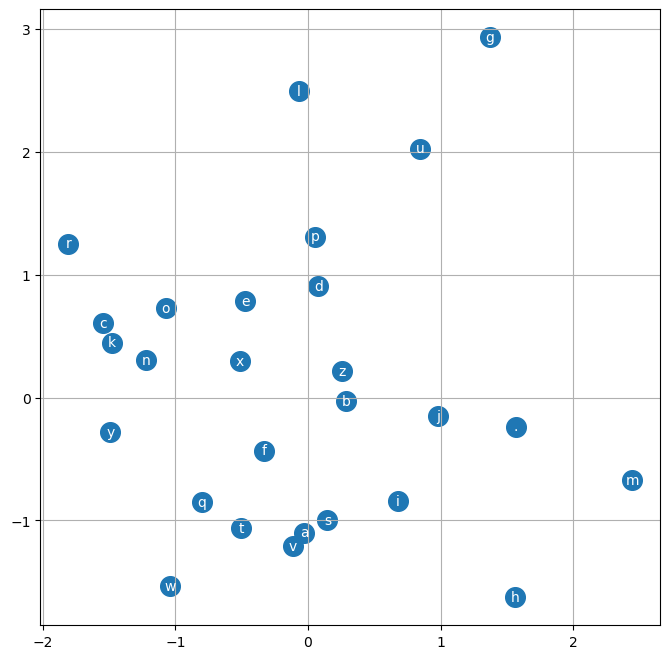

In [65]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
# Note, this wont work when we scale up embedding dimensions
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# ------------ Scaling up embeddings ---------------
We will use the same code as above

In [66]:
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80% 
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


In [68]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 4]), torch.Size([182580]))

In [69]:
vocab_size = len(itos)
n_embd = 40
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden ), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

In [70]:
sum(p.nelement() for p in parameters) # number of parameters in total

38707

In [71]:
for p in parameters:
    p.requires_grad = True

In [72]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre # learning rates
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [73]:
lri, lossi, stepi = [], [], [] # learning rates used and losses

In [74]:
emb = C[Xtr]
emb.shape

torch.Size([182580, 4, 40])

In [75]:
max_steps = 250000
# Forward pass
for i in range(max_steps):

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (block_size * n_embd, ))

    emb = C[Xtr[ix]] # index into X to only grab ix rows 
    # -1 just lets pytorch figure out the value required
    h = torch.tanh(emb.view(-1, block_size * n_embd) @ W1 + b1) # concat our original emb so we can multiply weight and add bias
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass 
    for p in parameters:
        p.grad = None # reset weights    
    loss.backward()
    # Update
    # lr = lrs[i] # vary the learning rate, start off with small learning rate and go to large learning rate
    lr = 0.1 if lr < 100000 else (0.01 if lr < 200000 else 0.005)
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
     # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 250000: 30.4293


  10000/ 250000: 2.6742
  20000/ 250000: 2.5127
  30000/ 250000: 2.1250
  40000/ 250000: 2.1381
  50000/ 250000: 2.1298
  60000/ 250000: 1.9196
  70000/ 250000: 1.9759
  80000/ 250000: 2.1428
  90000/ 250000: 2.0011
 100000/ 250000: 2.0823
 110000/ 250000: 1.8483
 120000/ 250000: 2.1221
 130000/ 250000: 1.9772
 140000/ 250000: 2.1286
 150000/ 250000: 2.0202
 160000/ 250000: 2.1154
 170000/ 250000: 2.0087
 180000/ 250000: 1.9478
 190000/ 250000: 2.1521
 200000/ 250000: 1.9168
 210000/ 250000: 1.8539
 220000/ 250000: 1.9628
 230000/ 250000: 1.9375
 240000/ 250000: 2.1323


ValueError: x and y must have same first dimension, but have shapes (250000,) and (500000,)

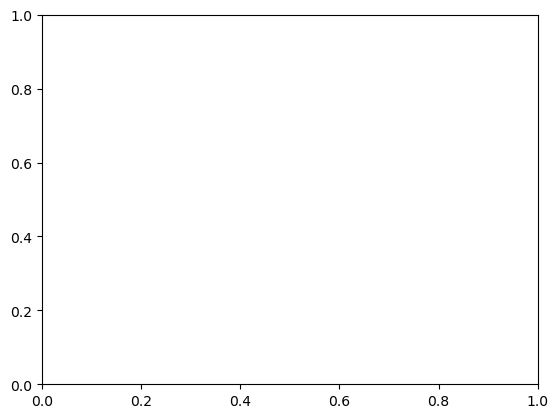

In [77]:
plt.plot(stepi, lossi)

In [78]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9807573556900024
val 2.138415575027466


# Task: improve the model
- things we can do 
- Increase embedding size
- increase middle hidden layer
- Optimize training (learning rate etc)
- batch size

In [80]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
qui.
havi.
kimlin.
taty.
salaysie.
rahnen.
delirit.
kaeli.
nellara.
christon.
legy.
dham.
pois.
quintes.
lilea.
jadis.
wraeloniel.
yxiz.
kaenah.


# <----- PART 3 ---->

In [81]:
vocab_size = len(itos)
n_embd = 40 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden ), generator=g) * (5/3)/((block_size * n_embd)**0.5) #ref https://pytorch.org/docs/stable/nn.init.html
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # scale down hidden layer weights
b2 = torch.randn(vocab_size, generator=g) * 0 # initialize bias that is 0

bngain = torch.ones((1, n_hidden)) # handles the movement away from initial gaussian activayion of hidden layer
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden)) 
bnstd_running = torch.ones((1, n_hidden)) 


parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # number of parameters in total

38907

In [82]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre # learning rates
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [83]:
lri, lossi, stepi = [], [], [] # learning rates used and losses

In [84]:
max_steps = 250000
batch_size = 100
# Forward pass
for i in range(max_steps):

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # sample a random batch of x inputs(3 characters in a row) and their corresponding output (one character)

    # Forward Pass
    emb = C[Xb] # index into X to only grab ix rows 
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # hidden layer preactivation 
    # normalise the hidden preactivation, as we don't want extreme values on activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True) 
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    h = torch.tanh(hpreact) # concat our original emb so we can multiply weight and add bias
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani  # update mean, hacky method
        bnstd_running  = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # Backward pass 
    for p in parameters:
        p.grad = None # reset weights    
    loss.backward()
    # Update
    # lr = lrs[i] # vary the learning rate, start off with small learning rate and go to large learning rate
    lr = 0.1 if lr < 100000 else (0.01 if lr < 200000 else 0.005)
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
     # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 250000: 3.3017
  10000/ 250000: 2.0435
  20000/ 250000: 2.0693
  30000/ 250000: 1.9232
  40000/ 250000: 1.9354
  50000/ 250000: 1.7789
  60000/ 250000: 1.7757
  70000/ 250000: 1.9568
  80000/ 250000: 1.9319
  90000/ 250000: 2.0976
 100000/ 250000: 2.0825
 110000/ 250000: 1.9093
 120000/ 250000: 1.7700
 130000/ 250000: 1.9695
 140000/ 250000: 2.0214
 150000/ 250000: 1.8235
 160000/ 250000: 1.9175
 170000/ 250000: 2.0235
 180000/ 250000: 1.8633
 190000/ 250000: 1.9775
 200000/ 250000: 1.8808
 210000/ 250000: 1.7954
 220000/ 250000: 2.0424
 230000/ 250000: 1.8670
 240000/ 250000: 1.8651


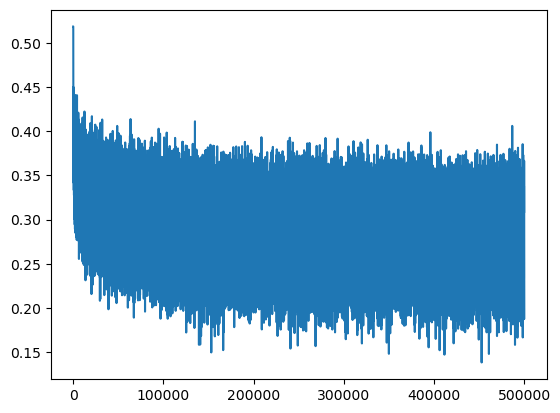

In [85]:
plt.plot(lossi)

In [86]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1 # hidden layer preactivation 
  # normalise the hidden preactivation, as we don't want extreme values on activation
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running+ bnbias
  h = torch.tanh(hpreact) # concat our original emb so we can multiply weight and add bias
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.360597610473633
val 2.5067265033721924


In [87]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1 # hidden layer preactivation 
      # normalise the hidden preactivation, as we don't want extreme values on activation
      hpreact = bngain * (hpreact - bnmean_running) / bnstd_running+ bnbias
      h = torch.tanh(hpreact) # concat our original emb so we can multiply weight and add bias
      logits = h @ W2 + b2 # (N, vocab_size)
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

nareah.
atifillianimith.
tetyahnaad.
nejaytube.
deniyat.
ianni.
neetanatinaiah.
yanetteu.
ymondie.
ediyn.
annie.
aitan.
iyoane.
olijarystin.
yeiritua.
eedye.
iiangtyelayna.
yahuan.
ovantisya.
immioson.


In [88]:
logits = torch.rand(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs[2]

tensor(0.0260)

Lets plot and view the hidden layer now. We can see most values take value pf -1 or 1

(array([49., 12.,  3.,  4.,  3.,  1.,  3.,  2.,  1.,  0.,  0.,  1.,  2.,
         1.,  0.,  2.,  3.,  0.,  2.,  1.,  2.,  0.,  2.,  0.,  2.,  1.,
         1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  3.,  1.,  1.,  3.,  2.,
         2.,  0.,  3.,  2.,  6.,  3.,  2.,  1.,  5.,  9., 56.]),
 array([-1.00000000e+00, -9.60000010e-01, -9.20000019e-01, -8.80000029e-01,
        -8.40000038e-01, -8.00000048e-01, -7.60000057e-01, -7.20000067e-01,
        -6.80000076e-01, -6.40000086e-01, -6.00000095e-01, -5.60000105e-01,
        -5.20000114e-01, -4.80000124e-01, -4.40000134e-01, -4.00000143e-01,
        -3.60000153e-01, -3.20000162e-01, -2.80000172e-01, -2.40000181e-01,
        -2.00000191e-01, -1.60000200e-01, -1.20000210e-01, -8.00002193e-02,
        -4.00002289e-02, -2.38418579e-07,  3.99997520e-02,  7.99997425e-02,
         1.19999733e-01,  1.59999723e-01,  1.99999714e-01,  2.39999704e-01,
         2.79999695e-01,  3.19999685e-01,  3.59999676e-01,  3.99999666e-01,
         4.39999657e-01,  4.7999

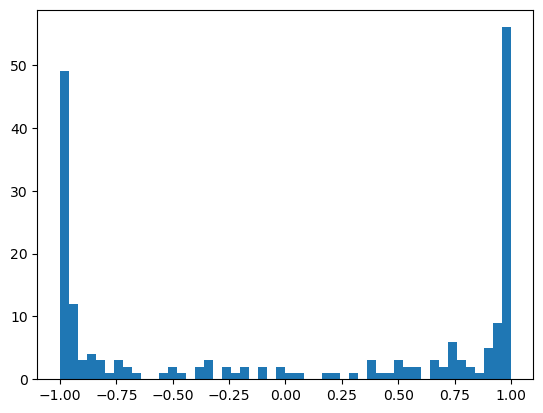

In [89]:
plt.hist(h.view(-1).tolist(), 50)

Plot the hidden preactivation layer, we can see the range is broad, so when we run them into tanh, they give close to max (1) and min (-1)

(array([ 1.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  3.,  1.,  5.,  1.,
         4.,  3.,  4.,  3.,  1.,  4.,  2.,  3.,  6.,  9.,  9.,  9.,  6.,
         5., 11.,  7.,  9., 12.,  9.,  5., 12.,  6.,  6., 10.,  3.,  3.,
         8.,  5.,  2.,  2.,  2.,  2.,  2.,  1.,  0.,  0.,  1.]),
 array([-9.96375561, -9.61191366, -9.26007172, -8.90822977, -8.55638783,
        -8.20454588, -7.85270393, -7.50086199, -7.14902004, -6.7971781 ,
        -6.44533615, -6.09349421, -5.74165226, -5.38981031, -5.03796837,
        -4.68612642, -4.33428448, -3.98244253, -3.63060059, -3.27875864,
        -2.92691669, -2.57507475, -2.2232328 , -1.87139086, -1.51954891,
        -1.16770697, -0.81586502, -0.46402308, -0.11218113,  0.23966082,
         0.59150276,  0.94334471,  1.29518665,  1.6470286 ,  1.99887054,
         2.35071249,  2.70255444,  3.05439638,  3.40623833,  3.75808027,
         4.10992222,  4.46176416,  4.81360611,  5.16544806,  5.51729   ,
         5.86913195,  6.22097389,  6.57281584,  6.92465778,

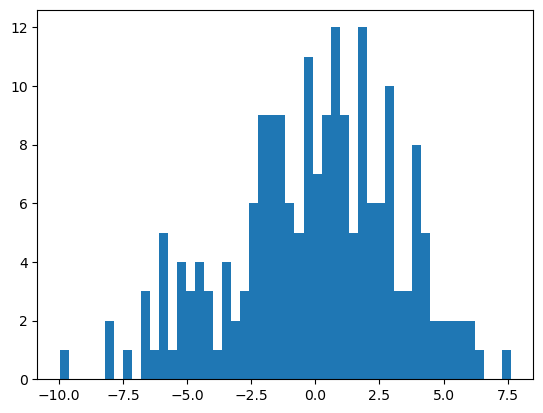

In [90]:
plt.hist(hpreact.view(-1).tolist(), 50) 

' \nNeurons are the x axis and examples are the y axis\n'

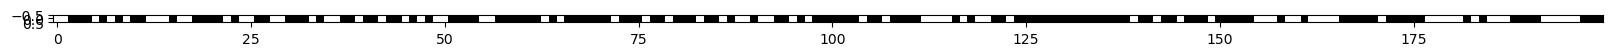

In [92]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest') # boolean tensor, white if true, black if false


''' 
Neurons are the x axis and examples are the y axis
'''

In [93]:
# calibrate the batch norm at the end of training
''' 
Get the mean and standard deviation accross entire training set.
This allows us to forward a single example to the model (i.e. one prompt)
If we don't do this, the model expects a batch to be provided each time

NOTE: this has been incorporated into the training loop already i.e. bnmean_running and bnstd_running
'''
with torch.no_grad():
    # pass the training set through
    emb     = C[Xtr]
    embcat  = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean / std over the entire training set
    bnmean  = hpreact.mean(0, keepdim=True)
    bnstd   = hpreact.std(0, keepdim=True) 

# <----- Objectification + Productionization ---->

In [95]:
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.rand((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNormld:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers trained with running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    def __call__(self, x):
        # calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean ) / torch.sqrt(xvar + self.eps) # normalise to unit variance
        self.out = self.gamma + xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum + xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum + xvar
        return self.out
    
    def parameters(self):
        return[self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh
        return self.out
    def parameters(self):
        return[]
        
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.rand((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47497


In [98]:
# minibatch construct
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

# forward pass
emb = C[Xb] # embed the characters into vectors
x = emb.view(emb.shape[0], -1) # concatenate the vectors
x

tensor([[0.7081, 0.3542, 0.1054,  ..., 0.9887, 0.0080, 0.2908],
        [0.7081, 0.3542, 0.1054,  ..., 0.5887, 0.3521, 0.3265],
        [0.6396, 0.6123, 0.5504,  ..., 0.0574, 0.0711, 0.8033],
        ...,
        [0.7081, 0.3542, 0.1054,  ..., 0.7568, 0.6050, 0.5705],
        [0.7081, 0.3542, 0.1054,  ..., 0.2886, 0.5549, 0.4912],
        [0.7081, 0.3542, 0.1054,  ..., 0.9887, 0.0080, 0.2908]],
       grad_fn=<ViewBackward0>)

In [99]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

TypeError: unsupported operand type(s) for @: 'builtin_function_or_method' and 'Tensor'

In [100]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

AttributeError: 'builtin_function_or_method' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')